# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"><img src="https://github.com/logicalclocks/hopsworks-tutorials/blob/master/images/icon102.png?raw=1" width="38px"></img> **Hopsworks Feature Store** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 02: Training Pipeline</span>


This is the second part of the quick start series of tutorials about predicting customers that are at risk of churning with the Hopsworks Feature Store.

This notebook explains how to read from a feature group and create training dataset within the feature store.

You will train the model using XGBoost model, although it could just as well be trained with other machine learning frameworks such as Scikit-learn, PySpark, TensorFlow, and PyTorch. You will also perform some of the exploration that can be done in Hopsworks, notably the search functions and the lineage.

## 🗒️ This notebook is divided into the following sections:
1. Select the features you want to train the model on.
2. Preprocess of features.
3. Create a dataset split for training and validation data.
4. Load the training data.
5. Train the model.
6. Explore feature groups and views via the UI.

![tutorial-flow](https://github.com/logicalclocks/hopsworks-tutorials/blob/master/images/03_model.png?raw=1)

In [1]:
!pip install -U hopsworks --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 713.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.8/244.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

### <span style='color:#ff5f27'> 📝 Imports

In [2]:
import joblib
import os
from PIL import Image

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
import xgboost as xgb

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

## <span style="color:#ff5f27;"> 📡 Connecting to Hopsworks Feature Store </span>

In [3]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

Copy your Api Key (first register/login): https://c.app.hopsworks.ai/account/api/generated

Paste it here: ··········
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/630932
Connected. Call `.close()` to terminate connection gracefully.


---
## <span style="color:#ff5f27;"> 🔪 Feature Selection </span>

You will start by selecting all the features you want to include for model training/inference.

In [4]:
# Retrieve feature groups
customer_info_fg = fs.get_feature_group(
    name="customer_info",
    version=1,
)

demography_fg = fs.get_feature_group(
    name="customer_demography_info",
    version=1,
)

subscriptions_fg = fs.get_feature_group(
    name="customer_subscription_info",
    version=1,
)

In [5]:
# Select features for training data
selected_features = customer_info_fg.select_except(["customerid", "datetime"]) \
    .join(demography_fg.select_except(["customerid"])) \
    .join(subscriptions_fg.select_except(["datetime"]))

# uncomment this if you would like to view your selected features
# selected_features.show(5)

Recall that you created three feature groups in the previous notebook. If you had created multiple feature groups with identical schema and wanted to include them in the join you would need to include a prefix argument in the join to avoid feature name clash. See the [documentation](https://docs.hopsworks.ai/feature-store-api/latest/generated/api/query_api/#join) for more details.

---
## <span style="color:#ff5f27;">🤖 Transformation Functions </span>

You will preprocess the data using *min-max scaling* on numerical features and *label encoding* on categorical features. To do this you will simply define a mapping between features and transformation functions. This ensures that transformation functions such as *min-max scaling* are fitted only on the training data (and not the validation/test data), which ensures that there is no data leakage.

In [6]:
# Load transformation functions from the feature store
min_max_scaler = fs.get_transformation_function(name="min_max_scaler")
label_encoder = fs.get_transformation_function(name="label_encoder")

# Define lists of numerical and categorical features
numerical_features = ["tenure", "monthlycharges", "totalcharges"]
categorical_features = [
    "multiplelines", "internetservice", "onlinesecurity", "onlinebackup",
    "deviceprotection", "techsupport", "streamingmovies", "streamingtv",
    "phoneservice", "paperlessbilling", "contract", "paymentmethod", "gender",
    "dependents", "partner"
]

# Map features to their corresponding transformation functions
transformation_functions = {}

# For numerical features, use the min_max_scaler transformation
for feature in numerical_features:
    transformation_functions[feature] = min_max_scaler

# For categorical features, use the label_encoder transformation
for feature in categorical_features:
    transformation_functions[feature] = label_encoder

---
## <span style="color:#ff5f27;"> ⚙️ Feature View Creation </span>

The Feature Views allows schema in form of a query with filters, define a model target feature/label and additional transformation functions.
In order to create a Feature View you may use `fs.get_or_create_feature_view()`.

In [7]:
# Get or create the 'churn_feature_view'
feature_view = fs.get_or_create_feature_view(
        name = 'churn_feature_view',
        version = 1,
        labels=["churn"],
        transformation_functions=transformation_functions,
        query=selected_features,
)

The feature view is now visible in the UI.

![fv-overview](https://github.com/logicalclocks/hopsworks-tutorials/blob/master/churn/images/churn_tutofv.gif?raw=1)

---
## <span style="color:#ff5f27;">🏋️ Training Dataset </span>


In [9]:
# Split data into training, validation, and test sets
X_train, X_val, X_test, y_train, y_val, y_test = feature_view.train_validation_test_split(
    validation_size=0.2,
    test_size=0.1,
)

# Drop the 'customerid' column from the training set
X_train.drop('customerid', axis=1, inplace=True)

# Drop the 'customerid' column from the validation set
X_val.drop('customerid', axis=1, inplace=True)

# Drop the 'customerid' column from the test set
X_test.drop('customerid', axis=1, inplace=True)

Finished: Reading data from Hopsworks, using ArrowFlight (4.96s) 


In [10]:
X_train.head(3)

,contract,tenure,paymentmethod,paperlessbilling,monthlycharges,totalcharges,gender,seniorcitizen,dependents,partner,deviceprotection,onlinebackup,onlinesecurity,internetservice,multiplelines,phoneservice,techsupport,streamingmovies,streamingtv
0,0,0.819444,0,0,0.710579,0.632933,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0.527778,1,0,0.631737,0.361747,1,0,1,0,1,0,1,0,0,0,0,0,0
3,1,0.888889,2,1,0.915669,0.805695,0,0,1,1,1,0,0,0,0,0,1,1,1


In [12]:
y_train.head(20)

,churn
0,0
2,0
3,0
6,0
8,0
9,0
10,0
11,1
12,0
13,0


In [ ]:
# Display the normalized value counts of the target variable
y_train.value_counts(normalize=True)

Notice that the distribution is skewed, which is good news for the company considering that customers at risk of churning make up smaller part of customer base. However, as a data scientist should somehow address the class imbalance. There are many approaches for this, such as weighting the loss function, over- or undersampling, creating synthetic data, or modifying the decision threshold. In this example, you will use the simplest method which is to just supply a class weight parameter to our learning algorithm. The class weight will affect how much importance is attached to each class, which in our case means that higher importance will be placed on positive (curn) samples.

---
## <span style="color:#ff5f27;"> 🏃 Train Model</span>

Next you will train a model and set the bigger class weight for the positive class.

In [13]:
# Create an instance of the XGBClassifier with a specified scale_pos_weight
classifier = xgb.XGBClassifier(scale_pos_weight=3)

# Fit the classifier on the training data
classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

---
## <span style="color:#ff5f27;"> 👨🏻‍⚖️ Model Evaluation</span>

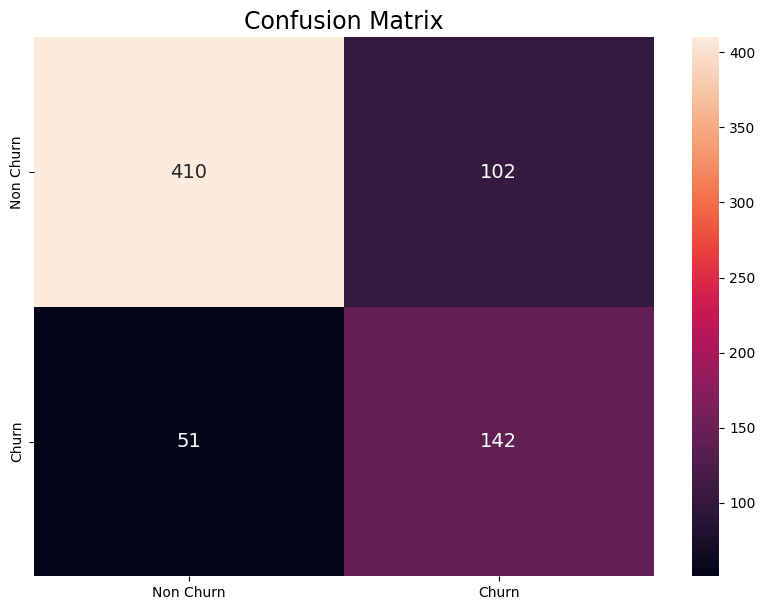

In [14]:
# Generate the confusion matrix using the true labels (y_test) and predicted labels from the classifier
conf_matrix = confusion_matrix(y_test, classifier.predict(X_test)).astype(int)

# Create a DataFrame from the confusion matrix results with appropriate labels
df_cm = pd.DataFrame(
    conf_matrix,
    ['Non Churn', 'Churn'],
    ['Non Churn', 'Churn'],
)

# Create a heatmap using seaborn with annotations
figure_cm = plt.figure(figsize=(10, 7))
figure_cm = sns.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='.10g')

# Set the title for the confusion matrix plot
plt.title('Confusion Matrix', fontsize=17)

# Display the plot
plt.show()

---
## <span style="color:#ff5f27;">🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance.

In [15]:
# Get the model registry
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


### <span style="color:#ff5f27;">⚙️ Model Schema</span>

The model needs to be set up with a [Model Schema](https://docs.hopsworks.ai/machine-learning-api/latest/generated/model_schema/), which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [16]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Create input schema using X_train
input_schema = Schema(X_train)

# Create output schema using y_train
output_schema = Schema(y_train)

# Create a ModelSchema object specifying the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Convert the model schema to a dictionary
model_schema.to_dict()

{'input_schema': {'columnar_schema': [{'name': 'contract', 'type': 'Int32'},
   {'name': 'tenure', 'type': 'float64'},
   {'name': 'paymentmethod', 'type': 'Int32'},
   {'name': 'paperlessbilling', 'type': 'Int32'},
   {'name': 'monthlycharges', 'type': 'float64'},
   {'name': 'totalcharges', 'type': 'float64'},
   {'name': 'gender', 'type': 'Int32'},
   {'name': 'seniorcitizen', 'type': 'int64'},
   {'name': 'dependents', 'type': 'Int32'},
   {'name': 'partner', 'type': 'Int32'},
   {'name': 'deviceprotection', 'type': 'Int32'},
   {'name': 'onlinebackup', 'type': 'Int32'},
   {'name': 'onlinesecurity', 'type': 'Int32'},
   {'name': 'internetservice', 'type': 'Int32'},
   {'name': 'multiplelines', 'type': 'Int32'},
   {'name': 'phoneservice', 'type': 'Int32'},
   {'name': 'techsupport', 'type': 'Int32'},
   {'name': 'streamingmovies', 'type': 'Int32'},
   {'name': 'streamingtv', 'type': 'Int32'}]},
 'output_schema': {'columnar_schema': [{'name': 'churn', 'type': 'int64'}]}}

In [17]:
# Specify the directory where the model files will be saved
model_dir = "churn_model"

# Check if the directory exists, and create it if it doesn't
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Specify the file name for the pickled model
pkl_file_name = model_dir + '/churnmodel.pkl'

# Save the trained classifier using joblib
joblib.dump(classifier, pkl_file_name)

# Save the confusion matrix heatmap as an image in the model directory
figure_cm.figure.savefig(model_dir + '/confusion_matrix.png')

In [18]:
# Create a model in the model registry
model = mr.python.create_model(
    name="churnmodel",
    description="Churn Model",
    input_example=X_train.sample(),
    model_schema=model_schema,
)

# Save the model to the specified directory
model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/316260 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/22227 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/129 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1568 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/630932/models/churnmodel/2


Model(name: 'churnmodel', version: 2)

## <span style="color:#ff5f27;">⏭️ **Next:** Part 03 </span>

In the following notebook you will use your model for batch inference.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/churn/3_churn_batch_inference.ipynb)